In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import ee
from functools import reduce

In [2]:
ee.Initialize()

In [3]:
city_names = pd.read_excel('./Data_Year_book_Area/North_China_Plain_city_name.xlsx')['CityName'].values

In [4]:
# define basic parameters, here we omitte the 1990_1992 beacaue 
# such year book is not avaliable
year_range = [f'{i}_{i+2}' for i in range(1993,2020,3)]

In [5]:
year_range

['1993_1995',
 '1996_1998',
 '1999_2001',
 '2002_2004',
 '2005_2007',
 '2008_2010',
 '2011_2013',
 '2014_2016',
 '2017_2019']

##### Step_1: Read and format the built-up area from year_book data

In [6]:
year_data = []

for i in range(1995,2020,3):
    area_df = pd.read_excel(f'./Data_Year_book_Area/YearBook_Built_up_Area_{i}.xlsx')
    area_filter = area_df[area_df['城市'].isin(city_names)]
    year_data.append(area_filter)

In [7]:
# stack all df together
Year_book_area = reduce(lambda left,right: pd.merge(left,right,on='城市'), year_data)

# rename the columns, here we convert the year to year_range for later comparison
Year_book_area.columns = ['Name_CN','Name_EN'] + [f'{i-2}_{i}' for i in list(range(1995,2020,3))]

# convert the df to long format
Year_book_area_indexed = Year_book_area.set_index(['Name_CN','Name_EN'])
Year_book_area_long = pd.DataFrame(Year_book_area_indexed.stack()).reset_index()
Year_book_area_long.columns = ['Name_CN','Name_EN','year_range','Area_Year_Book']

##### Step_2: calculate the area from classification results

In [8]:
North_china_plain_city = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_city_boundary")

In [9]:
# get the classification of this study
My_img = ee.Image("users/wangjinzhulala/North_China_Plain_Python/classificatioin_temporal_checked/Mosaic_only_forward")

In [10]:
# construc year:value dict to dilineate the value from mosaiced classifications
My_value = dict(zip(year_range,range(9,0,-1)))

In [11]:
# initiate an empty list to hold the result
Stats_df_list = []

for year in year_range:

    
    # get the classificaiton
    img_my   = ee.Image(My_img.gte(My_value[year]))
             
    # get the pixel count of my classifications
    Stats_my   = img_my.reduceRegions(reducer     = ee.Reducer.sum(), 
                                      collection  = North_china_plain_city, 
                                      scale       = 30,
                                      tileScale   = 1).select(['CityNameC','sum']).getInfo()
    
    # get the province and pixel-count 
    area_df = pd.DataFrame([i['properties'] for i in Stats_my['features']])
    area_df['year'] = year
    area_df.columns = ['Name_CN','Area_pixel','year_range']

    # append the area_sum to df_list
    Stats_df_list.append(area_df)

    # print out the process
    print(f'Area calculation of {year} finished!')

Area calculation of 1993_1995 finished!
Area calculation of 1996_1998 finished!
Area calculation of 1999_2001 finished!
Area calculation of 2002_2004 finished!
Area calculation of 2005_2007 finished!
Area calculation of 2008_2010 finished!
Area calculation of 2011_2013 finished!
Area calculation of 2014_2016 finished!
Area calculation of 2017_2019 finished!


##### Step_3: make the plot

In [16]:
# get the area form the df list
Area_GEE = pd.concat(Stats_df_list)

# merge the Year_book and GEE_are together
Area_to_compare = pd.merge(left=Year_book_area_long,right=Area_GEE,on=['year_range','Name_CN'])

# calculate the Area in km2
Area_to_compare['Area_pixel_km2'] = Area_to_compare['Area_pixel'] *30*30/1000/1000

In [14]:
# save the comparision_df to disk
Area_to_compare.to_csv('./Result/Area_compare_Year_Book.csv',index=False)

# read csv
Area_to_compare = pd.read_csv('./Result/Area_compare_Year_Book.csv')

In [15]:
Area_to_compare

,Name_CN,Name_EN,year_range,Area_Year_Book,Area_pixel,Area_pixel_km2
0,北京市,Beijing,1993_1995,467.0,1.100963e+06,990.866887
1,北京市,Beijing,1996_1998,488.0,1.290032e+06,1161.028578
2,北京市,Beijing,1999_2001,488.0,1.404240e+06,1263.815936
3,北京市,Beijing,2002_2004,1180.0,1.890004e+06,1701.003593
4,北京市,Beijing,2005_2007,1226.0,2.111570e+06,1900.412986
...,...,...,...,...,...,...
602,驻马店市,Zhumadian,2005_2007,45.0,1.747957e+06,1573.161272
603,驻马店市,Zhumadian,2008_2010,49.0,1.829860e+06,1646.874367
604,驻马店市,Zhumadian,2011_2013,65.0,2.066476e+06,1859.828520
605,驻马店市,Zhumadian,2014_2016,75.0,2.554744e+06,2299.269307


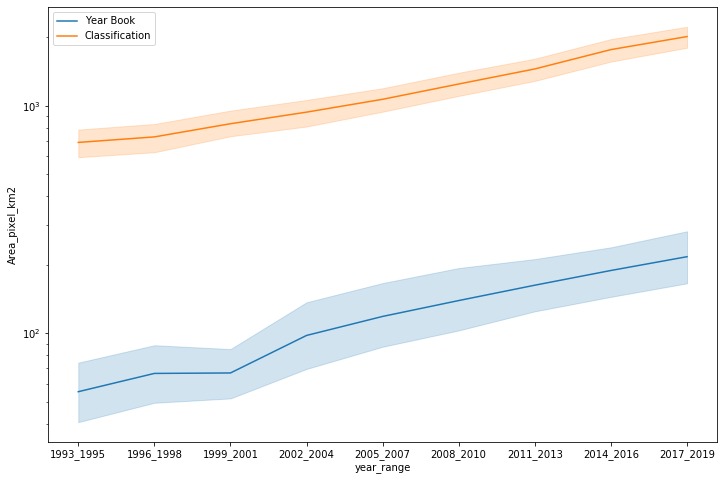

In [17]:
plt.figure(figsize=(12,8))

sns.lineplot(data=Area_to_compare,
            x='year_range',
            y = 'Area_Year_Book',
            label = 'Year Book')

sns.lineplot(data=Area_to_compare,
            x='year_range',
            y = 'Area_pixel_km2',
            label = 'Classification')

plt.yscale('log')

##### Compute the R2 and coeficiencts of each city using linear regression

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

Fit_para = {}

for name in Area_to_compare['Name_EN'].unique():
    
    # subset each city from the compare_df
    df = Area_to_compare[Area_to_compare['Name_EN'] == name]
    X = df['Area_pixel_km2'].values.reshape([-1,1])
    y = df['Area_Year_Book'].values.reshape([-1,1])
    
    # get the linear modle and use the model to predict the X
    linear_modle = LinearRegression().fit(X, y)
    pred = linear_modle.predict(X)
    
    # get parameters
    slope = linear_modle.coef_
    intercept = linear_modle.intercept_
    r2 = r2_score(y,pred)
    
    # store all parameters in the dict
    Fit_para[(name,'slope')] = slope[0]
    Fit_para[(name,'intercept')] = [intercept][0]
    Fit_para[(name,'r2')] = [r2]


In [19]:
Fit_df = pd.DataFrame(Fit_para).T.reset_index()
Fit_df.columns = ['City','para','value']

In [20]:
plt.figure(figsize=(12,8))
df = Fit_df[Fit_df['para']=='r2']
df

,City,para,value
2,Beijing,r2,0.822579
5,Tianjin,r2,0.986059
8,Shijiazhuang,r2,0.986232
11,Tangshan,r2,0.801520
14,Handan,r2,0.884144
...,...,...,...
191,Nanyang,r2,0.888312
194,Shangqiu,r2,0.758897
197,Xinyang,r2,0.970524
200,Zhoukou,r2,0.970612


<Figure size 864x576 with 0 Axes>

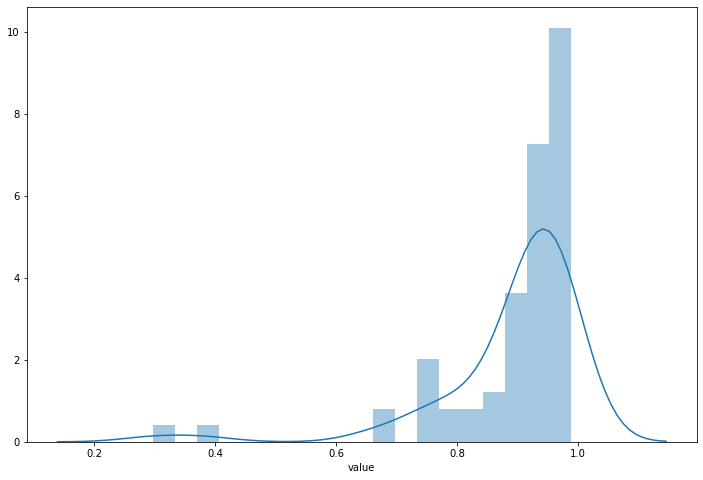

In [21]:
plt.figure(figsize=(12,8))
sns.distplot(df['value'])